<a href="https://colab.research.google.com/github/mezkymy/ecommerce-ds/blob/clean/Final_Project_DS_Rakamin_Batch_31_Kelompok_4_(Cobra).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# initialize random state
random_state = 25

# set plot style for whole notebook
sns.set_style('darkgrid')

In [3]:
# load csv file, create raw data (original copy) and dataframe (df) to manipulate
raw_data = pd.read_csv('Train.csv')
df = raw_data.copy()
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


# 1. Data Exploration

Source: [E-Commerce Shipping Data from Kaggle](https://www.kaggle.com/datasets/prachi13/customer-analytics)

## Context (copied from Kaggle):
An international e-commerce company based wants to discover key insights from their customer database. They want to use some of the most advanced machine learning techniques to study their customers. The company sells electronic products.

## 1.1 Descriptive Statistics Analysis

In [4]:
# check columns and null/non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


<b>Tidak ada kolom yang terdeteksi memiliki null value.</b>

In [5]:
# check if any ID is duplicated
df[df['ID'].duplicated()]

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N


<b>Tidak ada ID duplikat terdeteksi.</b>

Kolom ID dapat di-drop karena tidak akan digunakan pada tahapan selanjutnya.

In [6]:
# drop ID column
df.drop('ID', axis=1, inplace=True)
df.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,D,Flight,4,2,177,3,low,F,44,1233,1
1,F,Flight,4,5,216,2,low,M,59,3088,1
2,A,Flight,2,2,183,4,low,M,48,3374,1
3,B,Flight,3,3,176,4,medium,M,10,1177,1
4,C,Flight,2,2,184,3,medium,F,46,2484,1


In [7]:
# descriptive statistics for numerical values
df.describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


Terdapat sebuah kejanggalan pada feature `Discount_offered`, dimana nilai maksimalnya sebesar 65 sedangkan selisih jaraknya dengan Q3 (10) atau mean (13) sangat tinggi, sehingga diduga terdapat beberapa outlier/pencilan data yang mungkin perlu ditangani

In [8]:
# descriptive for categorical columns
categoricals = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
df[categoricals].describe()

,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
count,10999,10999,10999,10999
unique,5,3,3,2
top,F,Ship,low,F
freq,3666,7462,5297,5545


Tidak terdapat kejanggalan pada Categorical Data karena setiap kolom memiliki jumlah data yang sama dengan jumlah total baris data dan tidak terdapat nilai yang tidak diharapkan seperti huruf atau karakter yang dianggap sebagai kejanggalan.

## 1.2 Univariate Analysis


### 1.2.1 Pemeriksaan Rasio Data Target

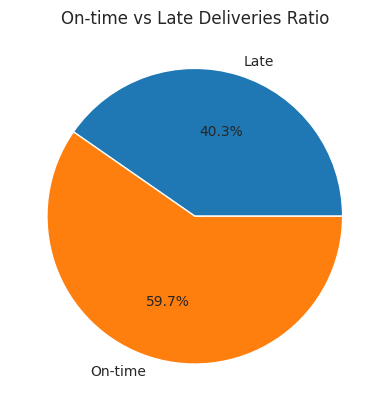

In [9]:
# check ratio of on-time vs late deliveries
df.groupby('Reached.on.Time_Y.N').size().plot(kind='pie', labels=['Late', 'On-time'], autopct='%.1f%%')

plt.title('On-time vs Late Deliveries Ratio')
plt.show()

Melalui grafik di atas, dapat diketahui bahwa proporsi pengiriman yang tepat waktu (On-time) sebesar 59,7% dan proporsi pengiriman yang terlambat (Late) sebesar 40,3%. Dapat disimpulkan bahwa sebagian besar pengiriman dilakukan tepat waktu, namun masih ada sebagian kecil pengiriman yang terlambat. Hal ini dapat menjadi fokus perbaikan untuk meningkatkan kualitas layanan dan kepuasan pelanggan.

Karena data sudah memiliki jumlah sampel yang cukup banyak dan tidak terlalu berbeda antara kelas satu dengan yang lain (tidak terlalu signifikan class imbalance-nya), maka tidak perlu dilakukan penyeimbangan lebih lanjut terhadap pada tahap pre-processing data.

### 1.2.2. Pemeriksaan Sebaran Data untuk Tiap Fitur/Variabel

In [10]:
# function to calculate bins based on Freedman-Diaconis (not used for now)
def bins_fd(col):
    n = col.count()
    q1, q3 = col.quantile([0.25, 0.75])
    range_tc = col.max() - col.min()
    IQR = q3 - q1
    return int(round(np.ceil(((n ** (1/3)) * range_tc)/(2 * IQR)), 0))

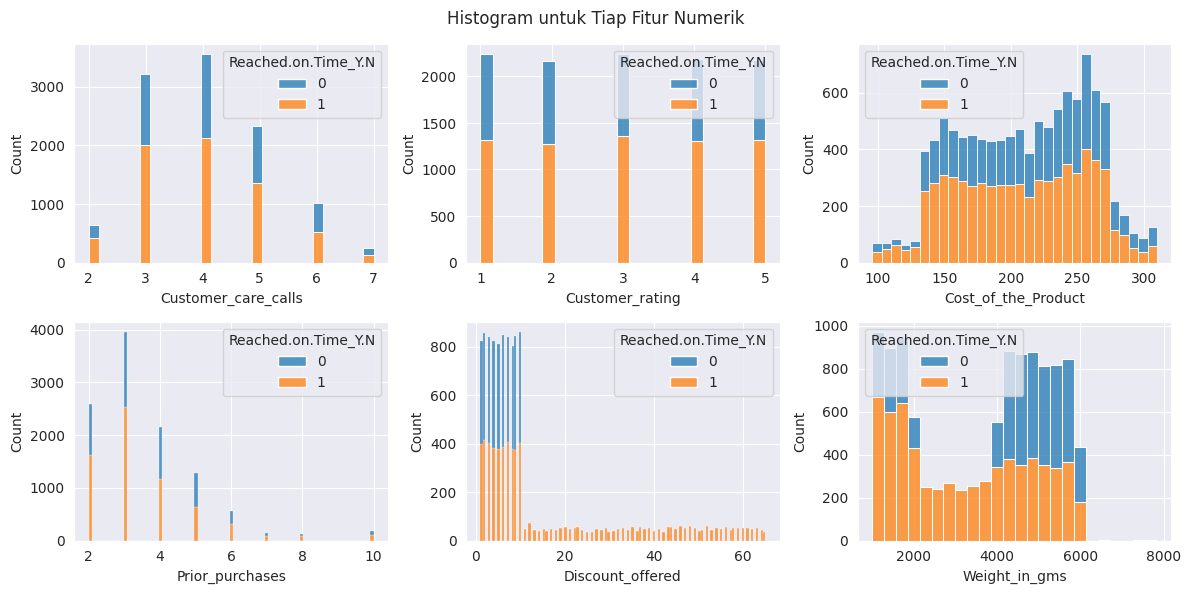

In [11]:
# histogram for numeric columns
numeric_columns = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

plt.suptitle('Histogram untuk Tiap Fitur Numerik')

i = 0
for y in axes:
    for ax in y:
        column = numeric_columns[i]
        sns.histplot(df, x=column, hue='Reached.on.Time_Y.N', multiple='stack', ax=ax)
        ax.minorticks_on()
        i += 1

fig.tight_layout(pad=1)
plt.show()

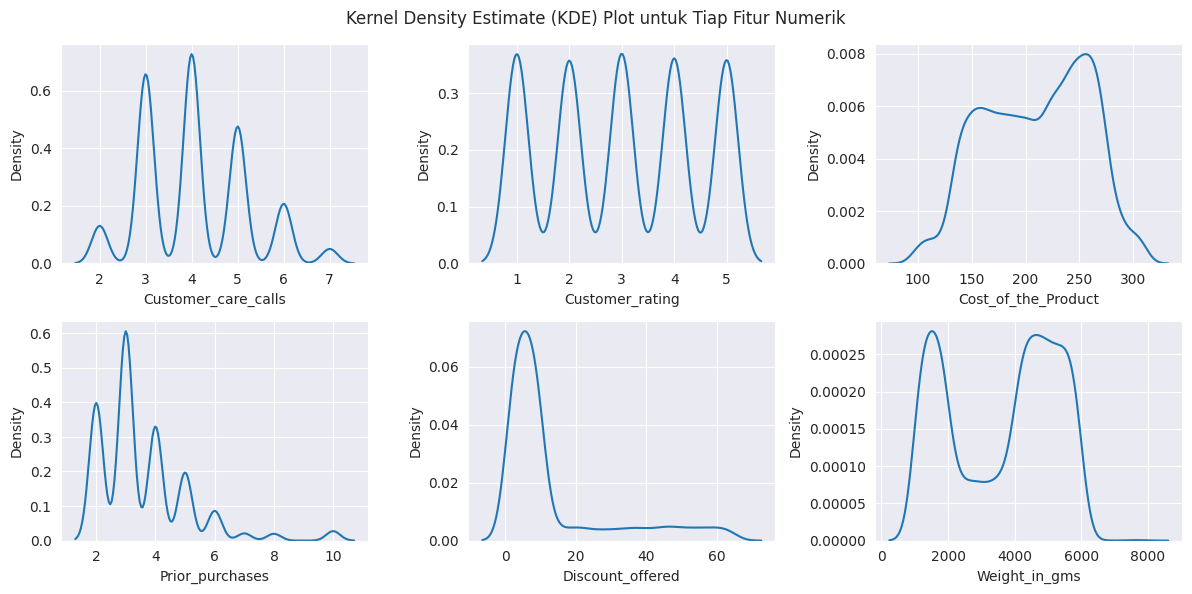

In [12]:
# KDEplot for numeric columns (sebagai pembanding tampilan)
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

plt.suptitle('Kernel Density Estimate (KDE) Plot untuk Tiap Fitur Numerik')

i = 0
for y in axes:
    for ax in y:
        column = numeric_columns[i]
        sns.kdeplot(df, x=column, ax=ax)
        ax.minorticks_on()
        i += 1

fig.tight_layout(pad=1)
plt.show()

Pada grafik sebaran fitur numerik terdapat beberapa hal yang menarik, diantaranya yaitu:

- Sebaran data berdasarkan fitur `Prior_purchase` membentuk positive skew
- Pada sebaran data berdasarkan fitur `Weight_in_gms` terdapat beberapa outlier pada nilai diatas 6000 (tidak terlalu terlihat pada grafik)
- Pada sebaran data berdasarkan fitur `Discount_offered`, terdapat nilai yang mendominasi yaitu pada nilai 0 - 10%, dimana barang yang diberikan <b>diskon di luar range tersebut tidak ada satupun yang terlambat</b>


Saat data pre-processing, perlu dilakukan scaling/standarisasi pada data numerik agar mempunyai range yang seragam.

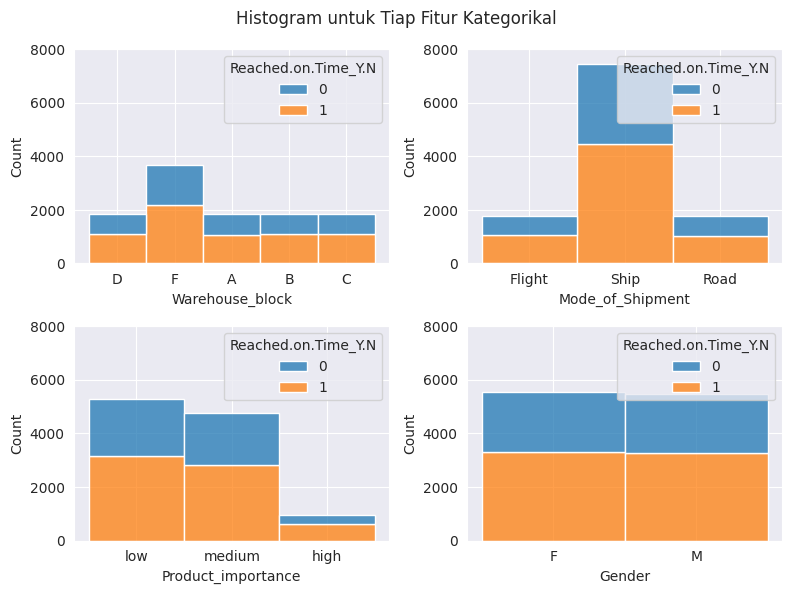

In [13]:
# Create histplot for categorical columns
categorical_columns = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

plt.suptitle('Histogram untuk Tiap Fitur Kategorikal')

i = 0
for y in axes:
    for ax in y:
        column = categorical_columns[i]
        sns.histplot(df, x=column, hue='Reached.on.Time_Y.N', multiple='stack', ax=ax) 
        ax.set_ylim(0, 8000)
        i += 1

fig.tight_layout(pad=1)
plt.show()

Insight Histogram Fitur Kategorikal:

- Berdasarkan Warehouse, barang paling banyak disimpan/dilayani oleh Warehouse F, sedangkan warehouse lainnya kurang lebih menampung jumlah barang yang sama
- Mayoritas pengiriman dilakukan melalui jalur laut (Ship)
- Jumlah barang yang tingkat kepentingannya tinggi (high) relatif sedikit
- Jumlah customer pria hampir setara dengan jumlah customer wanita, dengan rasio keterlambatan yang juga serupa
- Beberapa hal yang perlu ditindaklanjuti pada saat data pre-processing:
  - Untuk kolom `Gender`, dapat dilakukan mapping agar nilai "M" dan "F" menjadi 0 dan 1.
  - Untuk kolom `Product_importance`, dapat dilakukan label encoding karena kedua kolom tersebut memiliki nilai-nilai yang berurutan dan memiliki hubungan ordinal antara nilai-nilainya.
  - Untuk kolom `Warehouse_block` dan `Mode_of_Shipment`, dapat dilakukan one-hot encoding karena kolom tersebut tidak memiliki hubungan ordinal antara nilai-nilainya dan setiap nilai kategorikal dianggap sama pentingnya.




## 1.3 Multivariate Analysis

In [14]:
# ONLY UNCOMMENT AND RUN THIS CELL IF NECESSARY TO SHOW PAIR PLOT. CELL TAKES A LONG TIME TO EXECUTE

# # create pairplot for all numerical features
# sns.pairplot(df, hue='Reached.on.Time_Y.N')
# plt.show()

Terdapat segmentasi data yang secara visual cukup jelas terlihat pada beberapa pair plot. Secara visual, dapat diambil beberapa insight sebagai berikut:
- Pada `Discount_offered` terhadap `Weight_in_gms`, pada umumnya barang-barang yang beratnya di atas 4000 gram tidak diberikan diskon lebih besar dari 10% (kecuali untuk beberapa outlier).
- Tidak ditemukan barang terlambat pada barang yang diberikan diskon lebih dari 10%
- Barang dengan berat di antara 2000-4000 gram harganya ada di kisaran ~200 sampai ~300 dollar, dan tidak ada yang terlambat pengirimannya
- Terdapat beberapa data outlier jika dilihat berdasarkan berat barang (`Weight_in_gms`), yaitu barang-barang yang beratnya melebihi 6000 gram, namun untuk barang-barang tersebut tidak ada satupun yang mengalami keterlambatan

Berdasarkan hasil korelasi antara fitur, terdapat beberapa hal yang perlu dilakukan, yaitu:
- Beberapa data outlier pada berat barang (`Weight_in_gms`) yang perlu diobservasi lebih lanjut untuk memastikan apakah data tersebut valid atau tidak. Jika data tersebut valid, maka dapat dipertimbangkan untuk menggunakan teknik pre-processing seperti pengurangan dimensi (PCA) atau penanganan outlier untuk memperbaiki performa model.


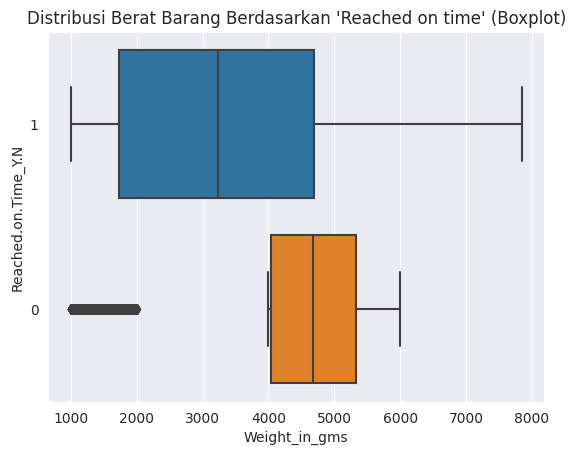

In [15]:
# check distribution of item weight based on 'reached on time'
sns.boxplot(data=df.astype({'Reached.on.Time_Y.N':'string'}), x="Weight_in_gms", y="Reached.on.Time_Y.N").set(title="Distribusi Berat Barang Berdasarkan 'Reached on time' (Boxplot)")

plt.minorticks_on()
plt.show()

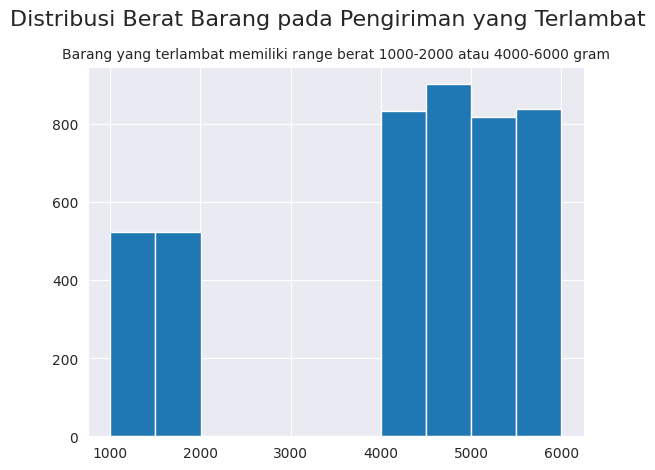

In [16]:
# create weight histplot for late deliveries
df[df['Reached.on.Time_Y.N'] == 0].hist(column = "Weight_in_gms")

plt.suptitle('Distribusi Berat Barang pada Pengiriman yang Terlambat', y=1, fontsize=16)
plt.title('Barang yang terlambat memiliki range berat 1000-2000 atau 4000-6000 gram', fontsize=10)
plt.show()

Berdasarkan data yang dimiliki, keterlambatan hanya terjadi pada barang yang memiliki berat di antara 1000-2000 gram atau 4000-6000 gram. Untuk barang yang memiliki berat 2000-4000 gram atau diatas 6000 gram tidak ada satupun yang mengalami keterlambatan pengiriman.

Pemeriksaan lebih lanjut dapat dilakukan terhadap barang yang berada pada rentang-rentang tersebut untuk dapat meneliti lebih lanjut pengaruh berat barang terhadap keterlambatan pengiriman.

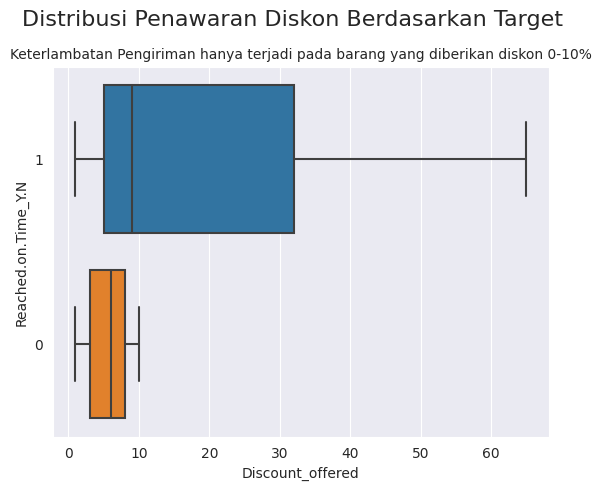

In [17]:
sns.boxplot(data=df.astype({'Reached.on.Time_Y.N':'string'}), x="Discount_offered", y='Reached.on.Time_Y.N')

plt.suptitle('Distribusi Penawaran Diskon Berdasarkan Target', y=1, fontsize=16)
plt.title('Keterlambatan Pengiriman hanya terjadi pada barang yang diberikan diskon 0-10%', fontsize=10)
plt.show()

Berdasarkan data yang dimiliki, keterlambatan hanya terjadi pada barang yang memiliki berat di antara 1000-2000 gram atau 4000-6000 gram. Untuk barang yang memiliki berat 2000-4000 gram atau diatas 6000 gram tidak ada satupun yang mengalami keterlambatan pengiriman.

Pemeriksaan lebih lanjut dapat dilakukan terhadap barang yang berada pada rentang-rentang tersebut untuk dapat meneliti lebih lanjut pengaruh berat barang terhadap keterlambatan pengiriman.

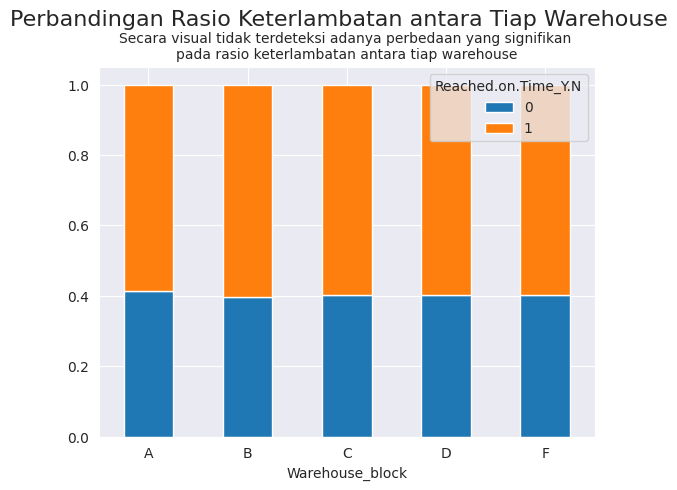

In [18]:
ct = pd.crosstab(index=df['Warehouse_block'],columns=df['Reached.on.Time_Y.N'], normalize='index')

ct.plot(kind='bar', rot=0, stacked=True)

plt.suptitle('Perbandingan Rasio Keterlambatan antara Tiap Warehouse', y=1, fontsize=16)
plt.title(f'Secara visual tidak terdeteksi adanya perbedaan yang signifikan \npada rasio keterlambatan antara tiap warehouse', fontsize=10)
plt.show()

(TODO)
Berdasarkan...

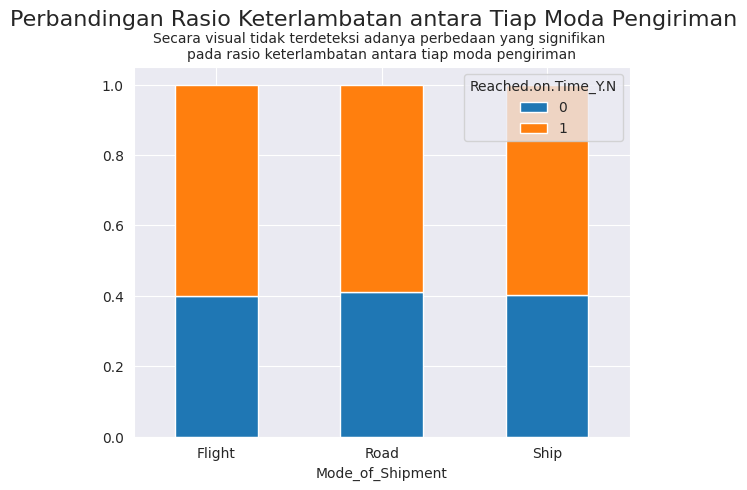

In [19]:
ct = pd.crosstab(index=df['Mode_of_Shipment'],columns=df['Reached.on.Time_Y.N'], normalize='index')

ct.plot(kind='bar', rot=0, stacked=True)

plt.suptitle('Perbandingan Rasio Keterlambatan antara Tiap Moda Pengiriman', y=1, fontsize=16)
plt.title(f'Secara visual tidak terdeteksi adanya perbedaan yang signifikan \npada rasio keterlambatan antara tiap moda pengiriman', fontsize=10)

plt.show()

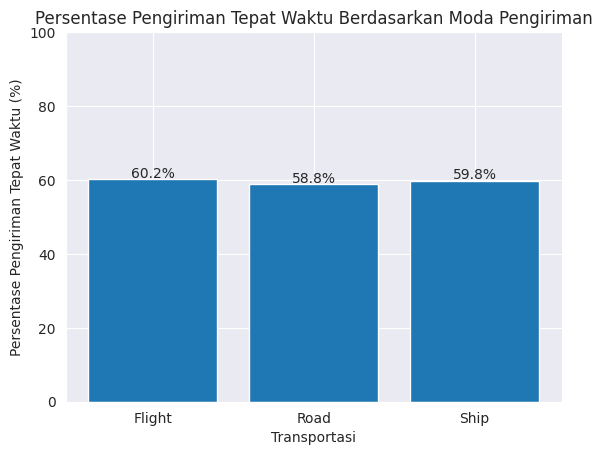

In [20]:
# Calculate late delivery percentage for each mode of transport
delay_by_shipment = df.groupby('Mode_of_Shipment')['Reached.on.Time_Y.N'].mean() * 100

# Membuat bar plot
plt.bar(delay_by_shipment.index, delay_by_shipment.values)

# Menambahkan label untuk setiap bar
for i, v in enumerate(delay_by_shipment.values):
    plt.text(i, v+0.5, str(round(v,1)) + '%', ha='center')

# Menambahkan label pada sumbu x dan y, serta judul grafik
plt.title('Persentase Pengiriman Tepat Waktu Berdasarkan Moda Pengiriman')
plt.xlabel('Transportasi')
plt.ylabel('Persentase Pengiriman Tepat Waktu (%)')
plt.ylim(0, 100)

# Menampilkan grafik
plt.show()

(TODO) Berdasarkan...

CATATAN: warna bar plot perlu diganti menjadi orange, atau nilai yang ditunjukkan diganti menjadi rasio keterlambatan (1-mean)

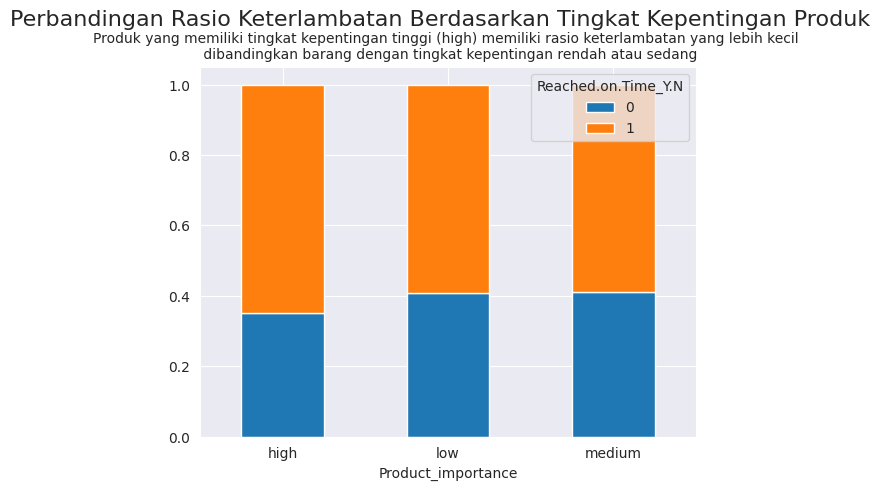

In [21]:
ct = pd.crosstab(index=df['Product_importance'],columns=df['Reached.on.Time_Y.N'], normalize='index')

ct.plot(kind='bar', rot=0, stacked=True)

plt.suptitle('Perbandingan Rasio Keterlambatan Berdasarkan Tingkat Kepentingan Produk', y=1, fontsize=16)
plt.title(f'Produk yang memiliki tingkat kepentingan tinggi (high) memiliki rasio keterlambatan yang lebih kecil \n dibandingkan barang dengan tingkat kepentingan rendah atau sedang', fontsize=10)

plt.show()

(TODO) Berdasarkan...

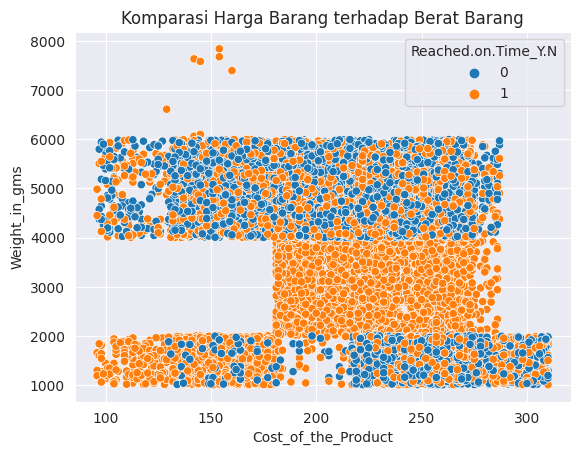

In [22]:
sns.scatterplot(data=df, x='Cost_of_the_Product', y='Weight_in_gms', hue='Reached.on.Time_Y.N')

plt.title('Komparasi Harga Barang terhadap Berat Barang')
plt.show()

Berdasarkan perbandingan harga terhadap berat barang, dapat terlihat segmentasi yang cukup jelas terhadap barang-barang pada rentang berat tertentu. Adapun secara manual sudah terlihat cukup jelas bahwa untuk barang pada rentang berat di atas 6000 gram, harga barang berada di sekitar 100-200 dan tidak ada yang terlambat. 

#### Kategorisasi Berat Barang
Adapun untuk melihat hubungan antara berat barang dengan  menambahkan fitur kategori berdasarkan berat barang, dengan rentang sebagai berikut:
1. Berat barang 2000 gram atau lebih ringan, kategori 'light' atau ringan
2. Berat barang di antara 2000-4000 gram, kategori 'medium' atau sedang
3. Berat barang di antara 4000-6000 gram (inklusif), kategori 'heavy' atau berat
4. Berat barang di atas 6000 gram, kategori 'very heavy' atau sangat berat

In [23]:
# categorize weight
cond = [
    (df['Weight_in_gms'] <= 2000),
    (df['Weight_in_gms'] > 2000) & (df['Weight_in_gms'] < 4000),
    (df['Weight_in_gms'] >= 4000) & (df['Weight_in_gms'] <= 6000),
    (df['Weight_in_gms'] > 6000),
]

val = ['light', 'medium', 'heavy', 'very heavy']

df['Weight_cat'] = np.select(cond, val)
df.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Weight_cat
0,D,Flight,4,2,177,3,low,F,44,1233,1,light
1,F,Flight,4,5,216,2,low,M,59,3088,1,medium
2,A,Flight,2,2,183,4,low,M,48,3374,1,medium
3,B,Flight,3,3,176,4,medium,M,10,1177,1,light
4,C,Flight,2,2,184,3,medium,F,46,2484,1,medium


In [24]:
df[df['Weight_cat'] == 'light'].describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,3245.000000,3245.000000,3245.000000,3245.000000,3245.000000,3245.000000,3245.000000
mean,4.626810,2.982435,214.697072,4.043143,16.922034,1494.070262,0.677658
std,1.334022,1.415738,58.632361,1.269722,18.471671,289.271956,0.467445
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,4.000000,2.000000,158.000000,3.000000,4.000000,1240.000000,0.000000
50%,5.000000,3.000000,232.000000,4.000000,8.000000,1498.000000,1.000000
75%,6.000000,4.000000,264.000000,5.000000,26.000000,1744.000000,1.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,2000.000000,1.000000


In [25]:
df[df['Weight_cat'] == 'medium'].describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,1786.000000,1786.000000,1786.000000,1786.000000,1786.000000,1786.000000,1786.0
mean,3.810190,3.003919,227.235162,3.298992,33.055991,3000.471445,1.0
std,0.943993,1.420335,28.710330,1.555390,18.751335,583.497470,0.0
min,2.000000,1.000000,181.000000,2.000000,1.000000,2003.000000,1.0
25%,3.000000,2.000000,202.000000,2.000000,17.000000,2493.000000,1.0
50%,4.000000,3.000000,226.500000,3.000000,34.000000,2994.000000,1.0
75%,4.000000,4.000000,252.000000,4.000000,49.000000,3516.000000,1.0
max,6.000000,5.000000,286.000000,10.000000,65.000000,3997.000000,1.0


In [26]:
df[df['Weight_cat'] == 'heavy'].describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,5960.000000,5960.000000,5960.00000,5960.000000,5960.000000,5960.000000,5960.000000
mean,3.818792,2.991275,202.72651,3.389933,5.524832,4984.313926,0.431208
std,0.954784,1.410860,44.56119,1.581473,2.922111,577.855397,0.495287
min,2.000000,1.000000,96.00000,2.000000,1.000000,4000.000000,0.000000
25%,3.000000,2.000000,166.00000,2.000000,3.000000,4486.000000,0.000000
50%,4.000000,3.000000,203.00000,3.000000,6.000000,4966.500000,0.000000
75%,4.000000,4.000000,241.25000,4.000000,8.000000,5487.000000,1.000000
max,6.000000,5.000000,287.00000,10.000000,47.000000,6000.000000,1.000000


In [27]:
df[df['Weight_cat'] == 'very heavy'].describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,8.0,8.00000,8.000000,8.0,8.0000,8.00000,8.0
mean,2.0,2.75000,146.375000,3.0,26.7500,7117.37500,1.0
std,0.0,1.28174,9.605616,0.0,15.0119,738.82125,0.0
min,2.0,1.00000,129.000000,3.0,5.0000,6064.00000,1.0
25%,2.0,2.00000,142.000000,3.0,18.5000,6486.00000,1.0
50%,2.0,2.50000,145.000000,3.0,27.5000,7494.50000,1.0
75%,2.0,3.25000,154.000000,3.0,38.0000,7651.00000,1.0
max,2.0,5.00000,160.000000,3.0,48.0000,7846.00000,1.0


Dengan pembagian kategori berat seperti di atas, dapat dilihat bahwa untuk kategori berat 'light' dan 'heavy', tidak ada satupun barang yang terlambat, yang dinilai dari nilai rata-rata targetnya yaitu persis di 1.

Untuk rentang harga barang berdasarkan kategori berat adalah sebagai berikut:
1. Kategori berat 'light', harga ada di rentang 96 - 310 atau sama dengan rentang secara keseluruhan (dapat dilihat pada Descriptive Statistic Analysis di poin 1.1)
2. Kategori berat 'medium', harga ada di rentang 181 - 286
3. Kategori berat 'heavy', harga ada di rentang 96 - 287
4. Kategori berat 'very heavy', harga ada di rentang 129 - 160

#### Kategorisasi Harga Barang
Berdasarkan temuan tersebut, harga barang mungkin dapat dikategorisasi juga menjadi:
1. Kategori 'low', dengan harga di bawah 181
2. Kategori 'medium', dengan harga di antara 181 - 287 (inklusif)
3. Kategori 'high', dengan harga di atas 287

In [28]:
# categorize cost
cond = [
    (df['Cost_of_the_Product'] < 181),
    (df['Cost_of_the_Product'] >= 181) & (df['Cost_of_the_Product'] <= 287),
    (df['Cost_of_the_Product'] > 287)
]

val = ['low', 'medium', 'high']

df['Cost_cat'] = np.select(cond, val)
df.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Weight_cat,Cost_cat
0,D,Flight,4,2,177,3,low,F,44,1233,1,light,low
1,F,Flight,4,5,216,2,low,M,59,3088,1,medium,medium
2,A,Flight,2,2,183,4,low,M,48,3374,1,medium,medium
3,B,Flight,3,3,176,4,medium,M,10,1177,1,light,low
4,C,Flight,2,2,184,3,medium,F,46,2484,1,medium,medium


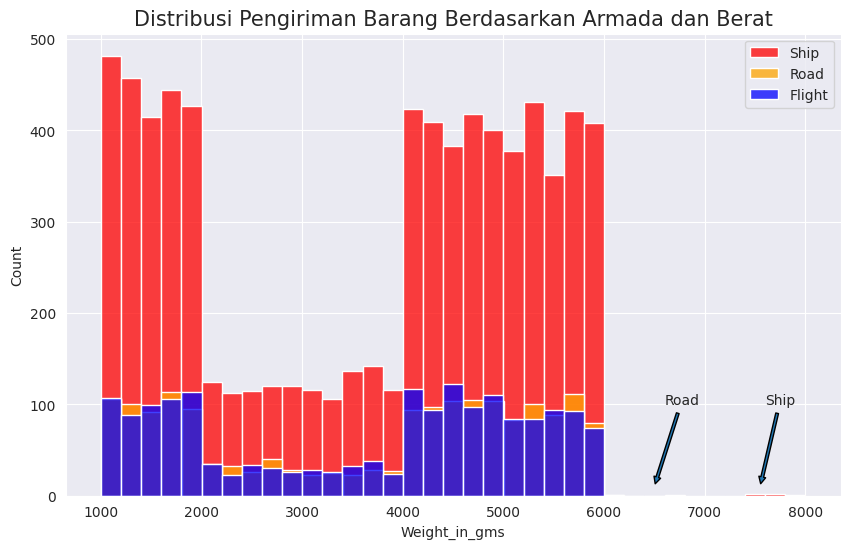

In [29]:
#Filtering Kolom
flight = df[df['Mode_of_Shipment']=='Flight']
ship = df[df['Mode_of_Shipment']=='Ship']
road = df[df['Mode_of_Shipment']=='Road']

#Visualisasi Distribusi Barang
plt.figure(figsize=(10,6))
sns.histplot(x='Weight_in_gms', binwidth=200, color='red', data=ship, label='Ship')
sns.histplot(x='Weight_in_gms', binwidth=200, color='orange', data=road, label='Road')
sns.histplot(x='Weight_in_gms', binwidth=200, color='blue', data=flight, label='Flight')

#Judul
plt.title('Distribusi Pengiriman Barang Berdasarkan Armada dan Berat', fontsize=15)

#Keterangan Tambahan
plt.annotate('Road',
            xy=(6500,10), xytext=(6600, 100), arrowprops=dict(ec='black', arrowstyle='simple',))
plt.annotate('Ship',
            xy=(7550,10), xytext=(7600, 100), arrowprops=dict(ec='black', arrowstyle='simple',))

#Legenda
plt.legend(loc=1)
plt.show()

Terdapat beberapa barang yang memiliki berat di atas 6000 gram, dimana barang yang berada pada rentang 6000-7000 gram hanya dikirimkan melalui jalur darat ('Road'), sedangkan barang yang memiliki berat di atas 7000 gram dikirimkan hanya melalui jalur laut ('Ship').

Barang-barang yang memiliki berat di atas 6000 gram jumlahnya relatif sedikit dan tidak ada satupun yang mengalami keterlambatan.

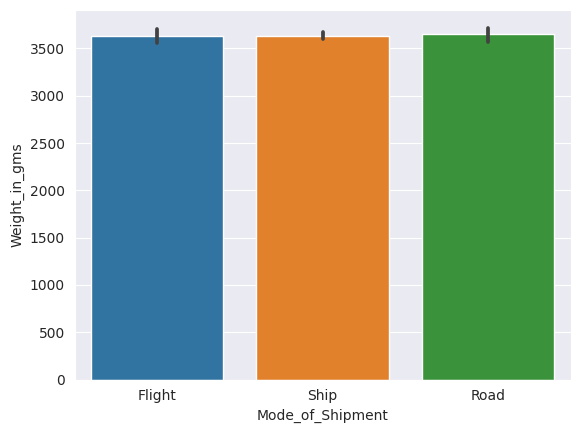

In [30]:
# average weight per mode of shipment
sns.barplot(x='Mode_of_Shipment', y='Weight_in_gms', estimator='mean', data=df)
plt.show()

Pada analisis univariate, sudah terdeteksi bahwa mayoritas pengiriman dilakukan menggunakan jalur laut (moda 'Ship' atau kapal). Namun pada grafik di atas, jika dilihat berdasarkan rata-rata berat pengiriman barang pada tiap moda maka tiap moda memiliki rata-rata berat yang kurang lebih sama.

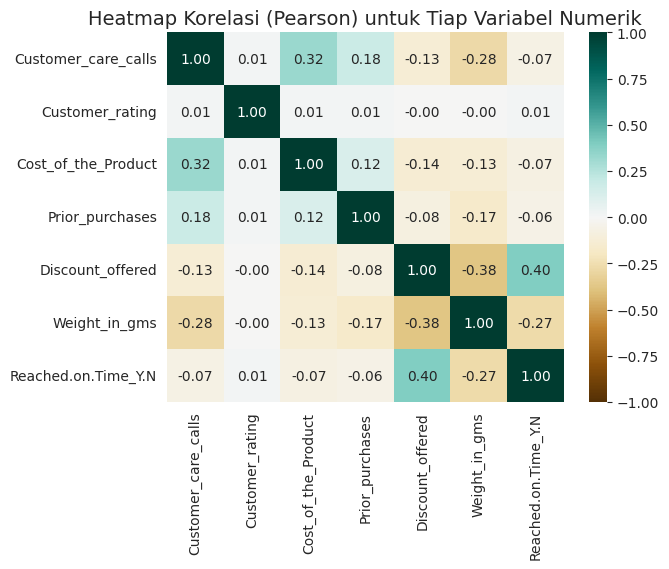

In [31]:
# correlation heatmap with pearson
fig, ax = plt.subplots()
sns.heatmap(df.corr(method='pearson', numeric_only=True), annot=True, cmap='BrBG', vmin=-1, vmax=1, fmt='.2f')

plt.title('Heatmap Korelasi (Pearson) untuk Tiap Variabel Numerik', fontsize=14)
plt.show()

Berdasarkan hasil heatmap yang dibuat korelasi antar fitur beragam dengan range 1 sampai -1. Semakin mendekati 1 atau -1 maka korelasi semakin kuat, sedangkan semakin mendekati 0 maka korelasi semakin lemah. Beberapa nilai korelasi yang paling relevan adalah sebagai berikut:

- `Discount_offered` dengan `Reached.on.Time_Y.N` berkorelasi sedang positif, sedangkan `Weight_in_gms` dengan `Reached.on.Time_Y.N` berkorelasi lemah negatif
- `Discount_offered` dengan `Weight_in_gms` berkorelasi sedang negatif (dapat mengakibatkan multikolinearitas pada model linear)
- `Cost_of_the_Product` dengan `Customer_care_calls` berkorelasi sedang positif
`Customer_rating` memiliki korelasi yang sangat kecil terhadap seluruh fitur lainnya, termasuk keterlambatan pengiriman

Berdasarkan hasil korelasi antar fitur & target, terdapat beberapa hal yang mungkin perlu dilakukan, yaitu:

  - `Discount_offered` dan `Weight_in_gms` memiliki korelasi yang cukup signifikan, sehingga perlu dilakukan pengecekan terhadap adanya multikolinearitas antara kedua fitur tersebut. Jika ditemukan adanya multikolinearitas, salah satu fitur dapat dihapus atau digabungkan dengan fitur lain.
  - Korelasi antara `Cost_of_the_Product` dengan `Customer_care_calls` perlu diperhatikan pada saat modelling. Jika terdapat multikolinearitas, fitur yang memiliki korelasi lebih rendah dengan target (`Reached.on.Time_Y.N`) dapat dihapus atau digabungkan dengan fitur lain.
  - Fitur yang memiliki korelasi rendah dengan target (`Reached.on.Time_Y.N`) namun memiliki korelasi yang tinggi dengan fitur lain juga perlu diperhatikan pada saat modelling. Pada beberapa kasus, fitur tersebut mungkin dapat dihapus atau digabungkan dengan fitur lain untuk menghindari multikolinearitas dan meningkatkan akurasi model.


# 2. Data Pre-Processing

In [32]:
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder

## 2.1 Data Cleansing

Sebelum melakukan pemrosesan lebih lanjut, data dipisah terlebih dahulu menjadi fitur dan target, lalu dipisah lebih lanjut menjadi data train dan test. Data train akan digunakan untuk membentuk model, sedangkan data test akan digunakan untuk menguji model yang dihasilkan. Pada tahapan Data Cleansing, pembersihan data tidak dilakukan pada data test karena tiap entry pada data test dianggap sebagai data yang valid dan memang benar ada (bukan merupakan eror).

In [33]:
# split data into features & target
target = 'Reached.on.Time_Y.N'
features = df.loc[:, df.columns != target].columns
x_data = df[features]
y_data = df[target]

In [34]:
# split data menjadi 80% data train dan 20% data test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=random_state, stratify=y_data)

# check amount of data on train and test
print('banyaknya data train =', x_train.shape[0])
print('banyaknya data test =', x_test.shape[0])

# check if split is balanced based on target value
print('mean value of y on train =', y_train.mean())
print('mean value of y on test =', y_test.mean())

banyaknya data train = 8799
banyaknya data test = 2200
mean value of y on train = 0.5966587112171837
mean value of y on test = 0.5968181818181818


### 2.1.1 Handle missing values, duplicated data, dan outliers

Dari Bagian 1.1 (<i>Descriptive Statistics Analytics</i>), diketahui bahwa data <b>tidak memiliki missing value maupun data duplikat</b>, sehingga tidak perlu ditangani lebih lanjut.

Untuk memeriksa outlier, dua metode yang dapat digunakan adalah berdasarkan z-score dan IQR.

In [35]:
# memeriksa outlier dari tiap kolom numerik menggunakan z-score test
cats = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender', 'Weight_cat', 'Cost_cat']
nums = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']

zscore = pd.DataFrame()
outlier = pd.DataFrame()
filtered_zscore = np.array([True] * len(x_train))

for col in nums:
    zscore = abs(stats.zscore(x_train[col])) # hitung absolute z-scorenya
    outlier[col] = x_train[col][zscore>3]
    filtered_zscore = (zscore < 3) & filtered_zscore 

outlier.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151 entries, 7930 to 453
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Customer_care_calls  0 non-null      float64
 1   Customer_rating      0 non-null      float64
 2   Cost_of_the_Product  0 non-null      float64
 3   Prior_purchases      151 non-null    int64  
 4   Discount_offered     2 non-null      float64
 5   Weight_in_gms        0 non-null      float64
dtypes: float64(5), int64(1)
memory usage: 8.3 KB


In [36]:
# memeriksa outlier dari tiap kolom numerik menggunakan IQR
cats = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender', 'Weight_cat', 'Cost_cat']
nums = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']

outlier_iqr = pd.DataFrame()
filtered_IQR = np.array([True] * len(x_train))

for col in nums:
    Q1 = x_train[col].quantile(0.25)
    Q3 = x_train[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 2) ## changed modifier to 2 to increase min and max range
    high_limit = Q3 + (IQR * 2) ## changed modifier to 2 to increase min and max range
    outlier_iqr[col] = x_train[col][(df[col] < low_limit) | (df[col] > high_limit)]
    filtered_IQR = ((x_train[col] >= low_limit) & (x_train[col] <= high_limit)) & filtered_IQR

outlier_iqr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362 entries, 2068 to 7661
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Customer_care_calls  0 non-null      float64
 1   Customer_rating      0 non-null      float64
 2   Cost_of_the_Product  0 non-null      float64
 3   Prior_purchases      362 non-null    int64  
 4   Discount_offered     85 non-null     float64
 5   Weight_in_gms        0 non-null      float64
dtypes: float64(5), int64(1)
memory usage: 19.8 KB


<b>CATATAN: Hapus data y_train pada indeks yang sama dengan yang dihapus pada x_train</b>

In [37]:
# drop outlier menggunakan zscore
print(f'jumlah baris data train SEBELUM filter outlier: {len(x_train)}')

# get index of outliers
outlier_id = outlier.index
x_train_outlier_removed = x_train.drop(outlier_id)
y_train_outlier_removed = y_train.drop(outlier_id)

print(f'jumlah baris data train SETELAH filter outlier: {len(x_train_outlier_removed)}')
print(f'Pemeriksaan apakah jumlah baris x_train dan y_train sama: {len(x_train_outlier_removed) == len(y_train_outlier_removed)}')

jumlah baris data train SEBELUM filter outlier: 8799
jumlah baris data train SETELAH filter outlier: 8648
Pemeriksaan apakah jumlah baris x_train dan y_train sama: True


Jika penentuan outlier menggunakan basis z-score, 151 data merupakan data outlier berdasarkan `Prior_purchases` dan `Discount_offered`nya (sekitar 2% dari keseluruhan data train), sedangkan jika menggunakan IQR yang dimodifikasi (konstanta batas atas dan bawah diubah dari 1.5 menjadi 2.0), maka terdapat 362 data yang merupakan outlier (sekitar 4.2% dari data train). 

Karena jumlah outlier tidak terlalu banyak dan data yang tersisa masih cukup banyak, maka data outlier dapat dihapus jika memang dirasa tidak diperlukan.

Dalam tahap ini, dipilih metode <b>z-score</b> untuk menentukan dan menghapus data outlier. Jumlah data train berkurang dari 8799 menjadi 8649.

### 2.1.2 Feature Transformation

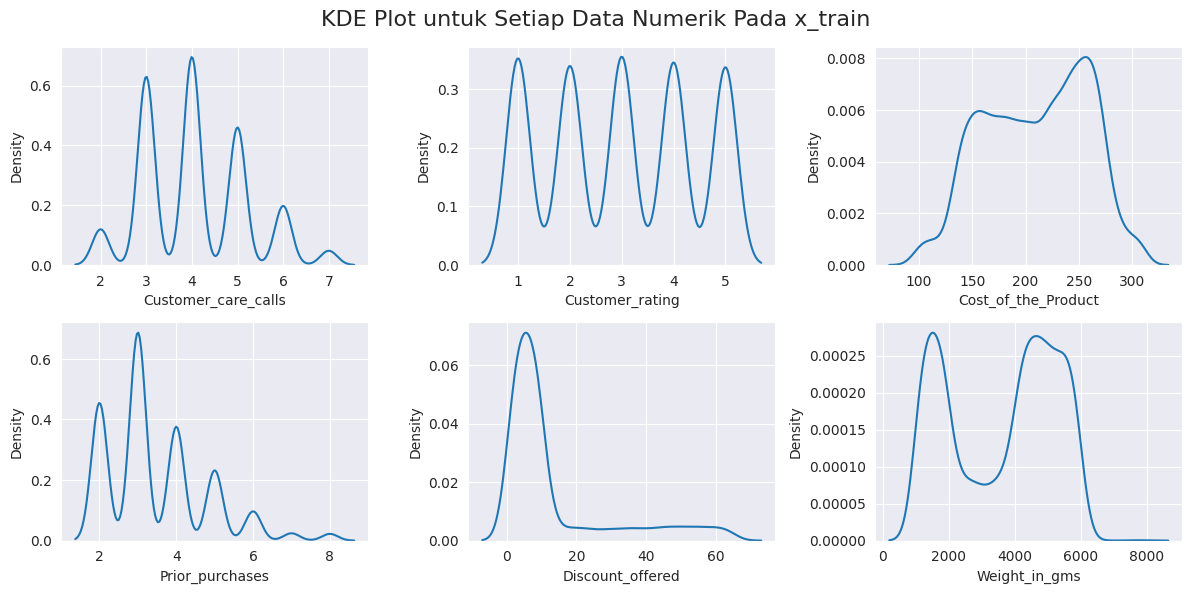

In [38]:
# Tinjau distribusi dari kolom-kolom numerik pada data menggunakan KDEplot dari data yang telah di smoothing
nums = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
fig.suptitle('KDE Plot untuk Setiap Data Numerik Pada x_train', fontsize=16)

i = 0
for y in axes:
    for ax in y:
        column = nums[i]
        sns.kdeplot(x_train_outlier_removed, x=column, ax=ax)
        ax.minorticks_on()
        i += 1

fig.tight_layout(pad=1)
plt.show()

In [39]:
# menghitung derajat skewness dari tiap data numerik
from scipy.stats import skew

skew_score = []                          
for i in nums:
  skew_score.append(round(skew(x_train_outlier_removed[i]),3))

df_skewness = pd.DataFrame({'fitur':nums, 'derajat skewness':skew_score})
df_skewness

,fitur,derajat skewness
0,Customer_care_calls,0.392
1,Customer_rating,0.006
2,Cost_of_the_Product,-0.164
3,Prior_purchases,1.004
4,Discount_offered,1.784
5,Weight_in_gms,-0.235


Setelah meninjau hasil kdeplot dan derajat skewness nya, kolom `Customer_care_calls`, `Customer_rating`, `Cost_of_the_Product`, dan `Weight_in_gms` dapat diasumsikan memiliki distribusi yang normal. Sehingga akan dilakukan transformasi untuk fitur lainnya yaitu `Prior_purchases` dan `Discount_offered`.

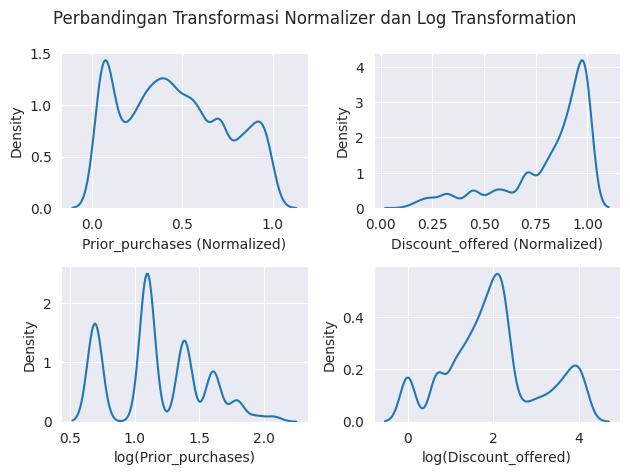

In [40]:
# Lakukan transformasi untuk menormalkan Prior_purchases dan Discount_offered, gunakan Normalizer dan Log Transformation
col = ['Prior_purchases', 'Discount_offered']

x_norm = Normalizer().fit_transform(x_train_outlier_removed[col].values.reshape(len(x_train_outlier_removed),2))
x_log = np.log(x_train_outlier_removed[col])

plt.subplot(2, 2, 1)
sns.kdeplot(x_norm[:,0])
plt.xlabel('Prior_purchases (Normalized)')

plt.subplot(2, 2, 2) 
sns.kdeplot(x_norm[:,1])
plt.xlabel('Discount_offered (Normalized)')

plt.subplot(2, 2, 3) 
sns.kdeplot(x_log['Prior_purchases'])
plt.xlabel('log(Prior_purchases)')

plt.subplot(2, 2, 4) 
sns.kdeplot(x_log['Discount_offered'])
plt.xlabel('log(Discount_offered)')

plt.suptitle('Perbandingan Transformasi Normalizer dan Log Transformation')
plt.tight_layout()
plt.show()

In [41]:
# Periksa skewness setelah transformasi
df_skewness = pd.DataFrame({'fitur':col, 
                            'skewness awal': skew(x_train_outlier_removed[col]),
                            'skewness normalizer': skew(x_norm),
                            'skewness log': skew(x_log)})

df_skewness

,fitur,skewness awal,skewness normalizer,skewness log
0,Prior_purchases,1.003699,0.201736,0.221924
1,Discount_offered,1.783852,-1.381430,0.221275


Dari nilai derajat skewness di atas, dapat dipilih transformasi Normalizer untuk `Prior_purchases` dan Log Transformation untuk `Discount_offered`.


Selanjutnya lakukan juga scaling untuk semua data numerik menggunakan MinMaxScaler. 

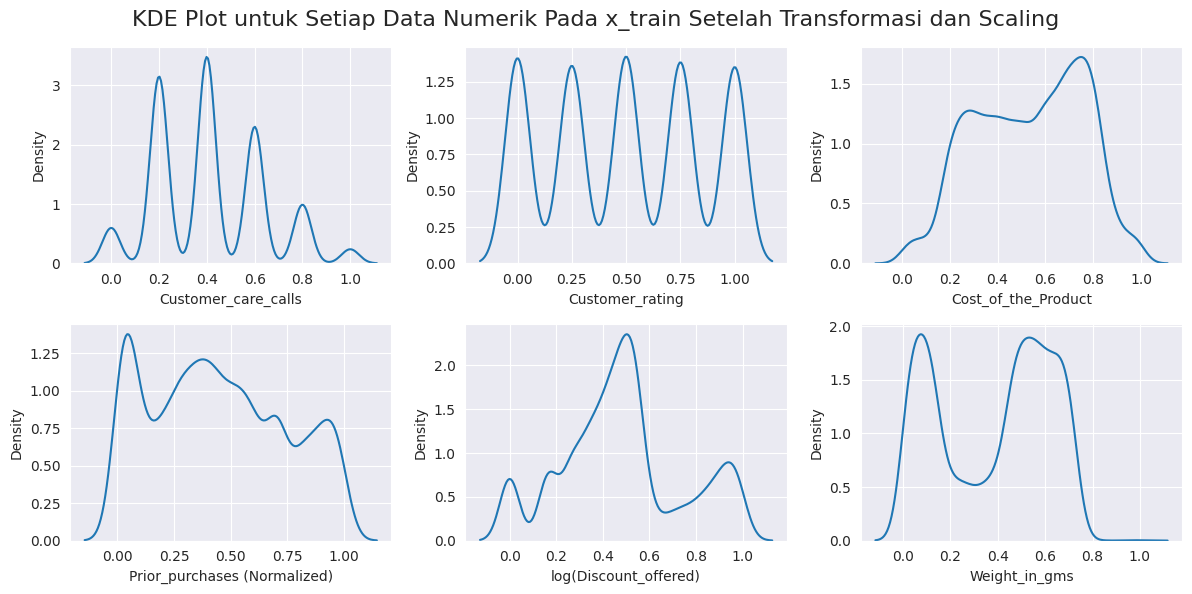

In [42]:
# KDEplot data numerik setelah transformasi + scaling
x_train_transformed = x_train_outlier_removed.copy()
x_train_transformed['Prior_purchases'] = x_norm[:,0]
x_train_transformed['Discount_offered'] = x_log['Discount_offered']
x_train_transformed[nums] = MinMaxScaler().fit_transform(x_train_transformed[nums].values.reshape(x_train_outlier_removed[nums].shape))

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

i = 0
for y in axes:
    for ax in y:
        column = nums[i]
        sns.kdeplot(x_train_transformed, x=column, ax=ax)
        ax.minorticks_on()
        i += 1

axes[1,0].set_xlabel('Prior_purchases (Normalized)')
axes[1,1].set_xlabel('log(Discount_offered)')
fig.suptitle('KDE Plot untuk Setiap Data Numerik Pada x_train Setelah Transformasi dan Scaling', fontsize=16)
fig.tight_layout(pad=1)
plt.show()

In [43]:
# cek deskriptif dan sebaran data setelah transformasi data
x_train_transformed.describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
count,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000
mean,0.412049,0.496473,0.533979,0.445313,0.479833,0.382126
std,0.227329,0.352738,0.224823,0.295951,0.260432,0.239062
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.250000,0.345794,0.193626,0.332095,0.121987
50%,0.400000,0.500000,0.551402,0.433124,0.466155,0.458145
75%,0.600000,0.750000,0.724299,0.703417,0.551598,0.588641
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Berdasarkan pemeriksaan plot dan statistik deskriptif, dapat dilihat bahwa standarisasi dan normalisasi sudah berhasil dilakukan, dimana sebaran data tiap fitur berada pada rentang 0 sampai 1.

Transformasi yang sama akan dilakukan pada data test juga sehingga model yang dibentuk dapat diterapkan kepada data test juga.

In [44]:
# apply transformation to test data


### 2.1.3 Feature Encoding

In [45]:
x_train_encoded = x_train_transformed.copy()

# OHE = 'Warehouse_block', 'Mode_of_Shipment' => bisa pakai sklearn onehotencoder
for cat in ['Warehouse_block', 'Mode_of_Shipment']:
    onehots = pd.get_dummies(x_train_encoded[cat], prefix=cat)
    x_train_encoded = x_train_encoded.join(onehots)
x_train_encoded.drop(['Warehouse_block_F', 'Mode_of_Shipment_Ship'], axis=1, inplace=True)

# Binary = 'Gender' => bisa pakai sklearn labelencoder
mapping_gender = {'F' : 0, 'M' : 1}
x_train_encoded['gender_map'] = x_train_encoded['Gender'].map(mapping_gender)

# Ordinal/Label = 'Product_importance' => bisa pakai sklearn ordinalencoder
mapping_product_importance = {'low' : 0, 'medium' : 1, 'high' :2}
x_train_encoded['product_importance_map'] = x_train_encoded['Product_importance'].map(mapping_product_importance)

# drop original column
x_train_encoded.drop(['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender'], axis=1, inplace=True)
x_train_encoded.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Weight_cat,Cost_cat,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,gender_map,product_importance_map
2068,0.6,0.75,0.383178,0.166522,0.858454,0.026004,light,low,0,0,1,0,1,0,0,1
4011,0.0,0.75,0.663551,0.592025,0.332095,0.698466,heavy,medium,0,1,0,0,0,0,1,1
2836,0.4,0.00,0.257009,0.012231,0.922326,0.099489,light,low,0,0,1,0,0,0,0,0
6785,0.4,0.50,0.434579,0.253729,0.466155,0.549890,heavy,medium,0,0,0,0,0,0,0,0
2562,0.4,0.50,0.443925,0.037195,0.911909,0.396348,medium,medium,0,0,0,1,0,0,0,2


### 2.1.3b Feature Encoding (with Sklearn)

In [46]:
# # Label Encoder
# label_encoder = LabelEncoder()
# x_train_transform['Gender_map']= label_encoder.fit_transform(x_train_transform['Gender'])
# x_train_transform['Gender_map'].unique()

In [47]:
# # One Hot Encoder
# OHE = OneHotEncoder(drop='first')
# data_OHE_blok = OHE.fit_transform(x_train_transform[['Warehouse_block']]).toarray()
# df_OHE_blok = pd.DataFrame(data_OHE_blok, columns=['Warehouse_block_' + i for i in OHE.categories_[0]])
# x_train_transform = pd.concat([x_train_transform, df_OHE_blok], axis=1)

# OHE = OneHotEncoder()
# data_OHE_mode = OHE.fit_transform(x_train_transform[['Mode_of_Shipment']]).toarray()
# df_OHE_mode = pd.DataFrame(data_OHE_mode, columns=['Mode_of_Shipment_' + str(i) for i in OHE.categories_[0]])
# x_train_transform = pd.concat([x_train_transform, df_OHE_mode], axis=1)

In [48]:
# # Ordinal Encoder
# # create a subset of the data with only the 'pekerjaan' column
# urutan = ['low', 'medium', 'high']

# # Inisialisasi encoder
# orde = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, categories=[urutan])

# # fit and transform OrdinalEncoder to the 'pekerjaan' column
# x_train_transform['product'] = orde.fit_transform(x_train_transform[['Product_importance']])

In [49]:
list(x_train_encoded.columns)

['Customer_care_calls',
 'Customer_rating',
 'Cost_of_the_Product',
 'Prior_purchases',
 'Discount_offered',
 'Weight_in_gms',
 'Weight_cat',
 'Cost_cat',
 'Warehouse_block_A',
 'Warehouse_block_B',
 'Warehouse_block_C',
 'Warehouse_block_D',
 'Mode_of_Shipment_Flight',
 'Mode_of_Shipment_Road',
 'gender_map',
 'product_importance_map']

Setelah melakukan encoding, beberapa kolom kategorikal pada data train diubah menjadi beberapa kolom untuk mempermudah pembentukan model:
1. `Warehouse_block` diubah menjadi 4 kolom menggunakan One-Hot Encoding
2. `Mode_of_Shipment` diubah menjadi 2 kolom menggunakan One-Hot Encoding
3. `gender` diubah menjadi kolom binary, dimana 0 = Female dan 1 = Male
4. `product_importance` diubah menjadi kolom ordinal, dimana 0 = low, 1 = medium, dan 2 = high 

Transformasi yang sama akan dilakukan pada data test juga sehingga model yang dibentuk dapat diterapkan kepada data test juga.

In [50]:
# apply transformation to test data


### 2.1.4 Handle Class Imbalance

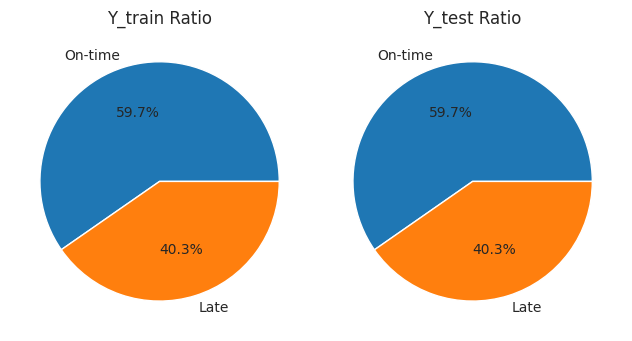

In [51]:
# check ratio on on-time vs late deliveries
plt.subplot(1, 2, 1)
plt.title('Y_train Ratio')
y_train.value_counts().plot.pie(labels=['On-time', 'Late'], autopct='%.1f%%')
plt.ylabel('')

plt.subplot(1, 2, 2)
plt.title('Y_test Ratio')
y_test.value_counts().plot.pie(labels=['On-time', 'Late'], autopct='%.1f%%')
plt.ylabel('')

# Add a title to the whole plot
fig.suptitle('Ratio of Late vs On-time Deliveries for Train and Test Data', fontsize=16, fontweight='bold', y=1.1)

plt.tight_layout(pad=1)
plt.show()

# CATATAN: urutan warna perlu disesuaikan dengan grafik sebelumnya (on-time/1 = orange, late/0= biru)

Pembagian rasio keterlambatan pada data train maupun data test serupa karena sudah dilakukan stratifikasi berdasarkan target pada tahap data splitting. Rasio yang mendekati 60:40 dinilai masih cukup imbang sehingga tidak perlu dilakukan oversampling untuk menyeimbangkan rasio tersebut.

## 2.2 Feature Engineering

### 2.2.1 Feature Selection

In [52]:
# drop kolom kategori yang asli, karena sudah di-encoding, 
x_train_new = x_train_encoded.copy()
x_train_new[target] = y_train

In [53]:
x_train_new.describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,gender_map,product_importance_map,Reached.on.Time_Y.N
count,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000
mean,0.412049,0.496473,0.533979,0.445313,0.479833,0.382126,0.165009,0.167553,0.165587,0.167091,0.164431,0.160962,0.495606,0.598636,0.597017
std,0.227329,0.352738,0.224823,0.295951,0.260432,0.239062,0.371210,0.373491,0.371731,0.373078,0.370688,0.367517,0.500010,0.639643,0.490526
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.250000,0.345794,0.193626,0.332095,0.121987,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.400000,0.500000,0.551402,0.433124,0.466155,0.458145,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,0.600000,0.750000,0.724299,0.703417,0.551598,0.588641,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000


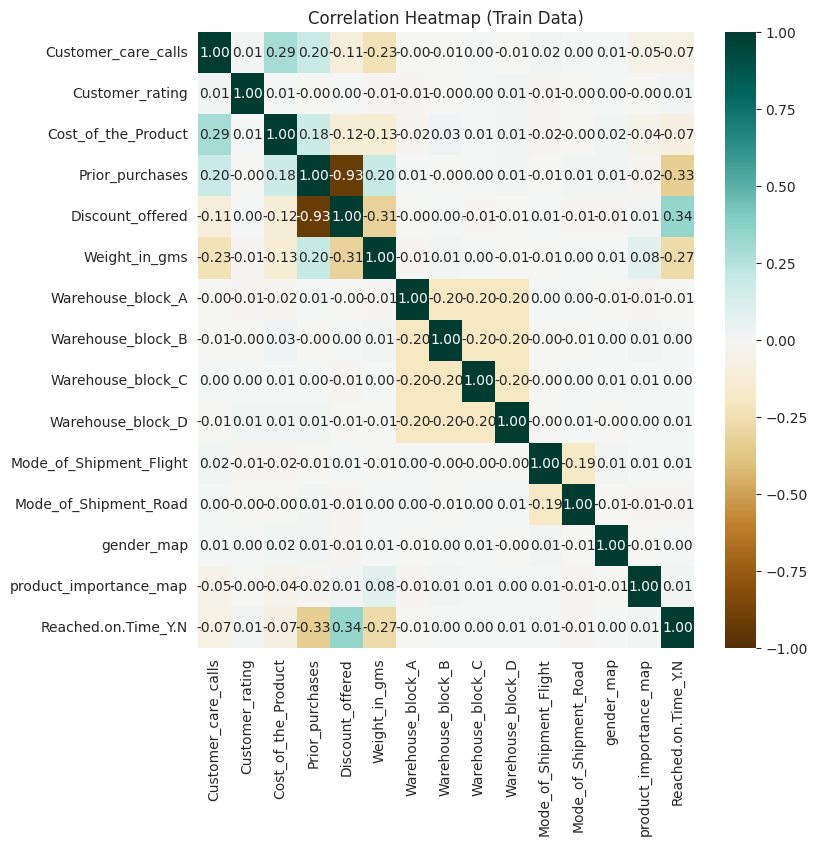

In [54]:
# buat corr dari df x_train_new
# correlation heatmap berubah lagi?
plt.figure(figsize=(8, 8))
sns.heatmap(x_train_new.corr(method='spearman', numeric_only=True), cmap='BrBG', annot=True, vmin=-1, vmax=1, fmt='.2f')

plt.title('Correlation Heatmap (Train Data)')
plt.show()

Setelah dilakukan pemeriksaan ulang korelasi antar fitur, ditemukan bahwa `Weight_in_gms` dengan `Discount_offered` dan `Cost_of_the_product` dengan `Customer_care_calls` memiliki korelasi yang cukup kuat.

Berdasarkan temuan tersebut, kedua kolom di atas dapat diekstrak menjadi suatu fitur baru yang merupakan gabungan dari kedua fitur untuk mencegah terjadinya multikolinearitas pada saat pembentukan model linear. Untuk model non-linear, semua variabel tersebut tetap dapat digunakan.

`Customer_rating`, `Warehouse_block`, `Mode_of_shipment`, dan `gender` memiliki korelasi yang sangat rendah terhadap semua fitur (kecuali fitur One-Hot lainnya), sehingga diduga aman untuk di-drop karena tidak akan mempengaruhi model.

In [55]:
# using ANOVA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

selector = SelectKBest(f_classif, k=10) # k is the number of features to be selected
x_train_new = selector.fit_transform(x_train_encoded, y_train)

columns = x_train_encoded.columns

feature_scores = list(zip(selector.scores_,columns))
sorted_feature_scores = sorted(feature_scores,reverse=True)

num_list = []
col_list = []
for i in range(len(columns)):
   num_list.append((sorted_feature_scores[i])[0])
   col_list.append((sorted_feature_scores[i])[1])

plt.bar(col_list,num_list)
plt.xticks(rotation=90)
plt.title('Ranking of Feature Importance Based on ANOVA')

plt.show()

ValueError: ignored

Berdasarkan nilai ANOVA fitur terhadap target, dapat diambil kesimpulan yang serupa dengan hasil uji korelasi; bahwa terdapat 5 fitur yang memiliki hubungan yang cukup terlihat terhadap target, dengan dua fitur mendominasi dibandingkan tiga fitur lainnya. 

Tanpa memilih terlebih dahulu jumlah fitur yang akan dipilih nantinya saat pembentukan model, secara garis besar pemilihan jumlah fitur dapat dibagi menjadi dua:

1. Menggunakan dua fitur, yaitu `Discount_offered` dan `Weight_in_gms`
2. Menggunakan lima fitur, dengan fitur diatas ditambah `Cost_of_the_product`, `Customer_care_calls`, dan `Prior_purchases`

### 2.2.2 Feature Extraction

Berdasarkan temuan pada bagian Feature Selection, kolom `Weight_in_gms` dan `Discount_offered` yang memiliki korelasi cukup kuat dapat digabung menjadi satu fitur baru, atau salah satu fitur dapat di drop, jika model yang akan dibentuk adalah model linear. Namun langkah ini dapat dilewati jika model yang dibentuk merupakan model non-linear, sehingga bersifat opsional.

Mengacu pada bagian 1.3 (Multivariate Analysis), jika dilihat berdasarkan fitur `Weight_in_gms`, `Cost_of_the_Product`, dan `Discount_offered` data dapat disegmentasi dengan cukup jelas berdasarkan fitur-fitur tersebut.

1. Berdasarkan berat, barang dapat dibagi menjadi empat kategori:
    - Ringan (< 2000 gram)
    - Sedang (2000-4000 gram)
    - Berat (4000-6000 gram)
    - Sangat Berat (>6000 gram)
2. Berdasarkan harga barang, dapat dibagi menjadi 

In [ ]:
x_train = x_train_encoded

# 3. Machine Learning Modelling & Evaluation

## 3.1. Decision Tree (with grid search) - Mezky

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree

selected_features = ['Discount_offered', 'Weight_in_gms', 'Cost_of_the_Product', 'Customer_care_calls', 'Prior_purchases']
dtree = DecisionTreeClassifier(random_state=random_state)

# hyperparameters for grid search
param = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4]
}

# grid search
gs = GridSearchCV(dtree, param, cv=5)
gs.fit(x_train[selected_features], y_train)

print(gs.best_params_)

In [ ]:
# create decision tree with best parameters and visualize using plot tree
best_dtree = DecisionTreeClassifier(**gs.best_params_, random_state=random_state)
best_dtree.fit(x_train[selected_features], y_train)

fig = plt.figure(figsize=(30,10))
_ = tree.plot_tree(best_dtree, feature_names=selected_features, class_names=['Late', 'On-time'], filled=True)

plt.show()

In [ ]:
# using graphviz
import graphviz 

dot_data = tree.export_graphviz(best_dtree, out_file=None, feature_names=selected_features, class_names=['Late', 'On-time'], filled=True, rounded=True, special_characters=True) 

graph = graphviz.Source(dot_data) 
graph

Random Forest (with GridSearch) - Rima

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

num = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
rf = RandomForestClassifier(random_state=42)

#hyperparameters
param = {
    'n_estimators': [100, 200],
    'max_depth': [2, 5, 10],
    'max_features': ['sqrt', 'log2', 'auto'],
    'criterion': ['gini', 'entropy']
}

rfg = GridSearchCV(rf, param, cv=5)
rfg.fit(x_train[num], y_train)
    
#best hyperparameters
print(rfg.best_params_)

In [ ]:
# Inisialisasi Model
rfc = RandomForestClassifier(random_state=42, max_depth=5, n_estimators=200)
rfc.fit(x_train[num], y_train)
eval_classification(rfc)

Logistic Regression (With Random Search) - Syafiq (In Progress)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

num = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
lr = LogisticRegression (random_state=42)

#hyperparameters
param = {
    'penalty': ['l2', 'l1'],
    'max_iter': [100],
    'solver': ['lbfgs'],
    'C': [float(x) for x in np.linspace(0.0001, 1, 100)]
}

lrr = RandomizedSearchCV(lr, param, cv=5)
lrr.fit(x_train[num], y_train)
    
#best hyperparameters
print(lrr.best_params_)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
#from sklearn.model_selection import cross_validate

num = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']

def eval_classification(model):
    y_pred = model.predict(x_test[num])
    y_pred_train = model.predict(x_train[num])
    y_pred_proba = model.predict_proba(x_test[num])
    y_pred_proba_train = model.predict_proba(x_train[num])
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    
    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))

In [ ]:
from sklearn.linear_model import LogisticRegression # import logistic regression dari sklearn
lr = LogisticRegression() # inisiasi object dengan nama logreg
lr.fit(x_train[num], y_train) # fit model regression dari data train
eval_classification(lr)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

penalty = ['l2']
C = [float(x) for x in np.linspace(0.001, 1, 100)]
hyperparameters = dict(penalty=penalty, C=C)

lr = LogisticRegression()
rs = RandomizedSearchCV(lr, hyperparameters, scoring='roc_auc', random_state=1, cv=5, n_iter=100)
rs.fit(x_train[num], y_train)
eval_classification(rs)

In [ ]:
show_best_hyperparameter(rs)